# Mintervention Aware Optimization

This notebook demonstrates Python algorithms for optimal control constrained by keepout sets. We compare barrier methods to the new Mintervention-aware optimization

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import numpy.linalg as LA
%matplotlib inline

# David McPherson's personal colors for plotting:
# Rows sorted by LAB L-value : 50, 20, 70
# Columns sorted by color : Rust, Turquoise, Sand, Indigo, Teal, Spring, Flesh, Magenta, Gray
colors = [['#cf4c34','#078752','#6333ed','#d6ca54','#0ca0ad','#2ea62a','#c96b0d','#d947bb','#777777'],
          ['#4C1C13','#073824','#2E186E','#575122','#065057','#164F14','#000000','#000000','#4D4D4D'],
          ['#FF745A','#0BD480','#9A7DF0','#FFF59C','#EEEEEE','#EEEEEE','#EEEEEE','#EEEEEE','#ABABAB']]

plt.rcParams['font.sans-serif'] = "Gill Sans"
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "Georgia"
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 100

In [2]:
# Import custom libraries
import dlqr
import dynamics as dyn

In [3]:
# Simplify plots
def muteAxes(ax,xrange,yrange):
    # Remove axis lines.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Set ticks
    ax.xaxis.set_ticks(xrange)
    ax.yaxis.set_ticks(yrange)

    ax.tick_params(direction='in')
    for xb in xrange:
        for yb in yrange:
            rect = mplt.patches.Rectangle((xb+0.05,yb+0.05),0.9,0.9,color='#EEEEEE')
            ax.add_patch(rect)
    ax.xaxis.label.set_color('#777777')
    ax.tick_params(axis='x', colors='#777777')
    ax.yaxis.label.set_color('#777777')
    ax.tick_params(axis='y', colors='#777777')

# Define the Dynamics to be used
The dynamics functions are accessed through an extension of the dynamics abstract base class (DynamicsABC) that provides handles to the flow and its (partial) derivatives.

In [4]:
# Double integrator dynamics
class InvertedPendulum(dyn.DynamicsABC):

    """
    Encodes double integrator dynamics

    Operates on a two-dimensional state space (z) with numbered states encoding:

      1. Angular position (w)
      2. Angular velocity (v)

    with the form:

    dw/dt = v
    dv/dt = u_0 + 1*sin(w)
    """

    def f(self,state,control):
        """Dynamic drift function of state over time

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            derivative (np.array): the time derivative of state over time according to these dynamics
        """
        Az = np.array([state[1],1*np.sin(state[0])])
        Bu = np.array([0,control[0]])
        derivative = Az + Bu
        return(derivative)

    def deriv_x(self,state,control):
        """Derivative of dynamics with respect to state

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            A (np.array): partial derivative of dynamics with respect to state
        """
        A = np.zeros((2,2))
        A[0,1] = 1
        A[1,0] = 1*np.cos(state[0])
        return(A)

    def deriv_u(self,state,control):
        """Derivative of dynamics with respect to control

        Args:
            state (np.array): state at which to evaluate the dynamics
            control (np.array): exogenous (control) input at which to evaluate the dynamics

        Returns:
            B (np.array): partial derivative of dynamics with respect to state
        """
        B = np.array([[0],[1]])
        return(B)

    def __init__(self):
        super(InvertedPendulum,self).__init__(2,1)

In [5]:
vehicle = InvertedPendulum()
timestep_length = 0.01

## Load the Barriers and test them

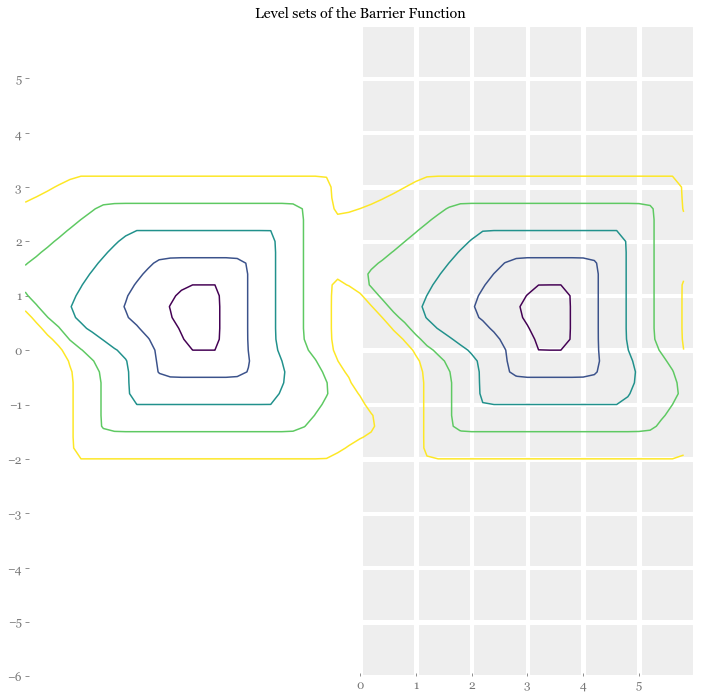

In [6]:
# Load the Safe Sets
import level_sets
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsStill_reachset.json")
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum7Tenths_reachset.json")
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsNopeV_reachset.json")
#safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum4Ninths_reachset.json")

# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(0,6),range(-6,6))

# Plot the safe set
delta = 0.2
x = np.arange(-6.0, 6.0, delta)
y = np.arange(-6.0, 6.0, delta)
X, Y = np.meshgrid(x, y)
z = np.array([safeLevel.value([ex,ey]) for ex,ey in zip(X.flatten(),Y.flatten())])
Z = z.reshape(X.shape)
CS = plt.contour(X, Y, Z, [0,0.5,1,1.5,2])

# Plot the gradient of the levels (the direction the controller will choose to go)
#u = np.array([safeLevel.gradient([ex,ey])[0] for ex,ey in zip(X.flatten(),Y.flatten())])
#U = u.reshape(X.shape)
#v = np.array([safeLevel.gradient([ex,ey])[1] for ex,ey in zip(X.flatten(),Y.flatten())])
#V = v.reshape(X.shape)
#plt.quiver(X,Y, U,V)

plt.title('Level sets of the Barrier Function')
plt.show()

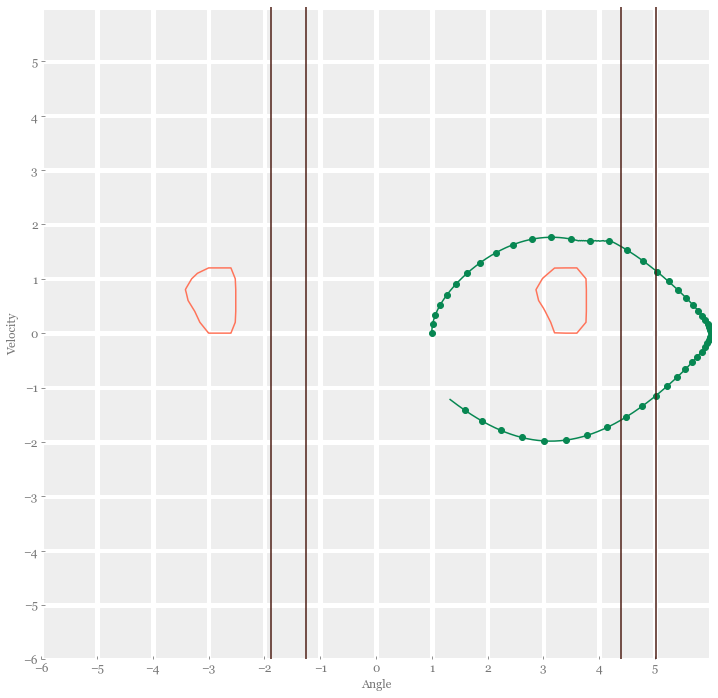

In [7]:
# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(-6,6))

# Test the safe set with controls that drive straight into the obstacle
vehicle = InvertedPendulum()
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
timestep_length = 0.01

# Forward simulate the dynamics with zero control
N = 1000
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))
states_init[:,0] = np.array([1,0])
for i in np.arange(0,N):
    control_init[:,i] = np.zeros((safe_vehicle.dimU,))
    states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])

# Plot the safe set intervention behavior on a mindless controller
CS = plt.contour(X, Y, Z, [0], colors = [colors[2][0]])
plt.xlabel("Angle")
plt.ylabel("Velocity")

plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,np.arange(0,N,20)],states_init[1,np.arange(0,N,20)],'ro',color=colors[0][1])

obsAngTick = 7
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
ys = np.array([-10,-10, 10, 10,-10])
#ys = ys * 0.12
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         ys,
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         ys,
         color=colors[1][0])

In [8]:
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)

## Set the Agent's goals

In [9]:
# Define the Agent's objective function
import objective_functions as of
import quadratic_objectives as qof
import avoidance_objective as caof

runningControlCost = qof.QuadraticControlCost(dlqr.QuadraticForm(vehicle.dimU,np.diag([0.05]),np.zeros((vehicle.dimU,1)),0))

Qprox = np.diag([1,1])
goal_state = np.array([0,0])
terminalCost = of.TerminalCost(qof.QuadraticStateCost(
        dlqr.QuadraticForm(vehicle.dimZ,Qprox,
                           -2*Qprox*np.matrix(goal_state).T,
                           np.dot(np.dot(goal_state.transpose(),Qprox),goal_state) )
        ) * 80)

Agent_objective = runningControlCost*1

## Optimize trajectory with iLQR

In [10]:
import ilqr

mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                            timestep_length,
                                                                            safe_vehicle,
                                                                            Agent_objective,
                                                                            terminal_cost = terminalCost * (1/timestep_length),
                                                                            neverRetreat=True,ITER_NUM=15)

Initialization's cost is  260.33305174566647
1 62.36004684415496
2 32.053812185574316
3 0.41424605751674315
4 0.1843946231591
5 0.15944087878092014
6 0.15493797779703966
7 0.15467207469039906
8 0.15427206383952335
9 0.1541579183694354
10 0.1541055699508354
11 0.15352203894552507
12 0.15340524196289856
13 0.15276309687683284
14 0.15262696793371525


<function matplotlib.pyplot.show(close=None, block=None)>

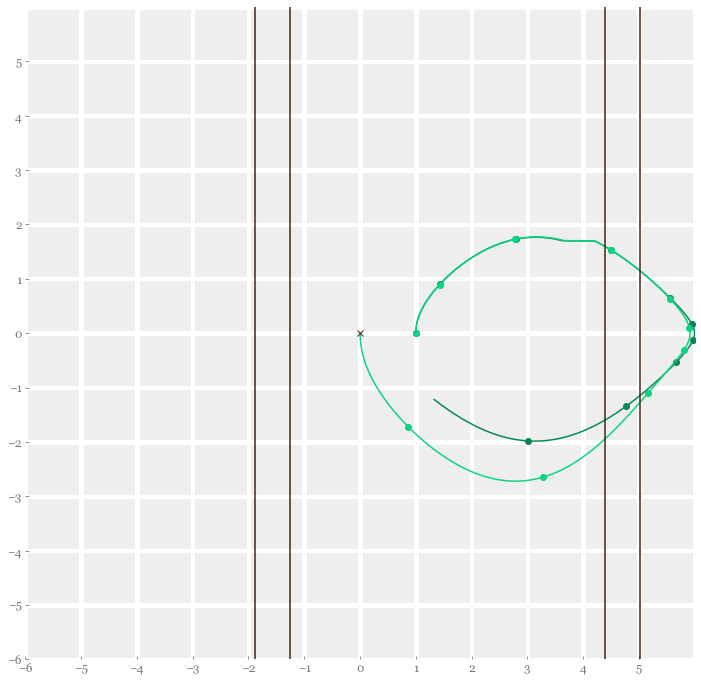

In [11]:
# Plot the resultant trajectories

# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(-6,6))

dotTimes = np.arange(0,N,100)
# Plot the initialization
plt.plot(states_init[0,:],states_init[1,:],color=colors[0][1])
plt.plot(states_init[0,dotTimes],
         states_init[1,dotTimes],
         'ro',color=colors[0][1])

# Plot the iterative LQR optimized trajectory
plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=colors[2][1])
plt.plot(mintervener_method_states[0,dotTimes],
         mintervener_method_states[1,dotTimes],
         'ro',color=colors[2][1])

# Plot the goal point
plt.plot(goal_state[0],goal_state[1],'x',color=colors[1][0])
# Plot the constraint
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         ys,
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         ys,
         color=colors[1][0])

plt.show

# Animate the Trajectory

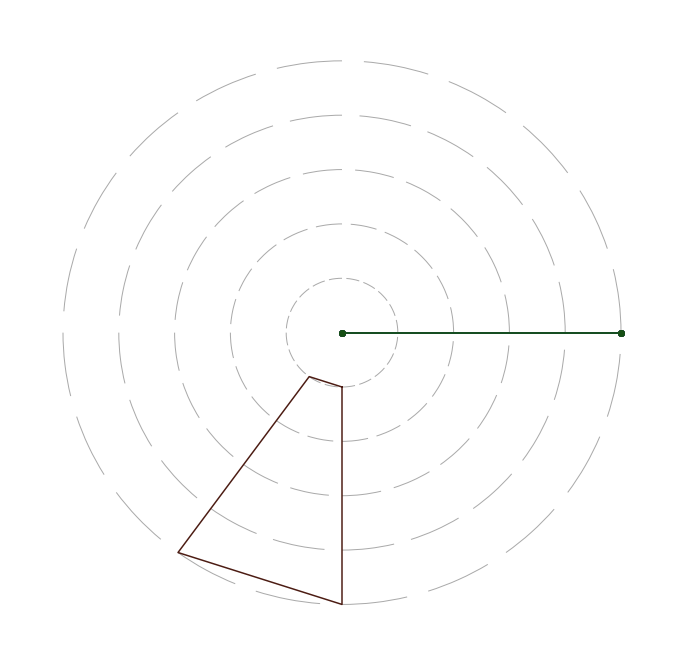

In [30]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

# Setup the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
# Remove axis lines.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set ticks
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.tick_params(direction='in')
# Set incremental tilings
angle_grid_spacing = 0.05
for rb in [1,2,3,4,5]:
    for ab in np.arange(0,1,angle_grid_spacing):
        arc = mplt.patches.Arc((0,0),2*rb,2*rb,
                                color='#AAAAAA',
                                theta1 = 360*ab,
                                theta2 = 360*(ab+0.75*angle_grid_spacing))
        ax.add_patch(arc)
# Draw the obstacle
#"""
ax.plot([1*np.sin(angle1),1*np.sin(angle2),5*np.sin(angle2),5*np.sin(angle1),1*np.sin(angle1)],
        [1*np.cos(angle1),1*np.cos(angle2),5*np.cos(angle2),5*np.cos(angle1),1*np.cos(angle1)],
        color=colors[1][0])
#"""
#ax.xaxis.label.set_color('#777777')
#ax.tick_params(axis='x', colors='#777777')
#ax.yaxis.label.set_color('#777777')
#ax.tick_params(axis='y', colors='#777777')

lines = []
for ii in range(0,6):
    line, = ax.plot([0,5], [0,0], 'o-', color=colors[1][ii])
    lines.append(line)

In [31]:
# initialization function: plot the background of each frame
def init():
    for line in lines:
        line.set_data([], [])
    return (lines)

In [32]:
# animation function. This is called sequentially
length = 5
def animate(i):
    for ii in range(0,6):
        trace = OptimizedTraces[ii]
        angle = trace[0,i]
        speed = trace[1,i]
        x = [0,length * np.sin(angle)]
        y = [0,length * np.cos(angle)]
        lines[ii].set_data(x, y)
    return (lines)

In [33]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig,
                               animate, init_func=init,
                               frames=1000,
                               interval=10, blit=True)
anim

In [34]:
writervideo = animation.FFMpegWriter(fps=60) 
anim.save("export/pendulumAgent_NoPeSpeedFiveTenthsObstacle.mp4", writer=writervideo)

In [17]:
import csv
with open('export/pendulumAgent_NoObstacle.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(mintervener_method_states[0,:])
    writer.writerow(mintervener_method_states[1,:])

# Batch Production
Generate some variance with a fixed constraint set for regressing upon.

In [12]:
# Plot the resultant trajectories
ys = [-10.0,-10.0, 10.0, 10.0,-10.0]

In [18]:
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsNopeV_reachset.json")

startingStates = [np.random.rand(2,) for ii in range(101)]
endingGoals = [np.random.rand(2,) for ii in range(101)]
for ii in range(101):
    while safeLevel.value(startingStates[ii]) < 0:
            startingStates[ii] = np.random.rand(2,)
    while safeLevel.value(endingGoals[ii]) < 0:
            endingGoals[ii] = np.random.rand(2,)
    startingStates[ii][0] = startingStates[ii][0]*6.28 - 6.28*0.4
    startingStates[ii][1] = startingStates[ii][1]*4 - 2
    endingGoals[ii][0] = endingGoals[ii][0]*6.28 - 6.28*0.4
    endingGoals[ii][1] = endingGoals[ii][1]*4 - 2

In [19]:
for ii in []:
    startingStates[ii] = np.random.rand(2,)
    endingGoals[ii] = np.random.rand(2,)
    startingStates[ii][0] = startingStates[ii][0]*6.28 - 6.28*0.4
    startingStates[ii][1] = startingStates[ii][1]*4 - 2
    endingGoals[ii][0] = endingGoals[ii][0]*6.28 - 6.28*0.4
    endingGoals[ii][1] = endingGoals[ii][1]*4 - 2
    print(startingStates[ii])
    print(endingGoals[ii])

[-0.85988307 -0.16661174]
[-1.81643102 -1.40251095]
[ 0.8219611  -0.43856732]
[-2.42643768 -1.13386402]


Initialization's cost is  13485.438027549806
1 10516.521197108801
2 5249.801882885489
3 5246.614006692144
4 5246.614006692144
5 5246.614006692144
6 5246.614006692144
7 5246.614006692144
8 5246.614006692144
9 5246.614006692144
10 5246.614006692144
11 5246.614006692144
12 5246.614006692144
13 5246.614006692144
14 5246.614006692144
Initialization's cost is  27933.728467166948
1 5623.759109850052
2 4908.513866925404
3 9.265400427644762
4 7.73550947123376
5 7.194657655096995
6 6.935142564129434
7 6.661623100725693
8 6.471947160772288
9 6.248541099069618
10 6.088802953849874
11 5.900819923568566
12 5.764582060090284
13 5.605203588610513
14 5.488165582961118
Initialization's cost is  26171.731145549667
1 719.109882357061
2 713.3176540103511
3 708.8921108866015
4 704.7486339833937
5 700.8489500481338
6 697.2117822504065
7 693.7948706158418
8 690.545922590683
9 687.4131802947503
10 684.346533177098
11 681.2974703239108
12 678.2146835660446
13 675.0385751248367
14 671.7211966340008
Initializatio

2 640.5061618270161
3 447.4694583557983
4 5.342261813907721
5 4.145927526159716
6 3.4744685921869167
7 3.1288722349194096
8 2.688266148428135
9 2.432568853387051
10 2.141928734111951
11 1.9555962274637326
12 1.7632631710825848
13 1.6286162343813224
14 1.5010240801593864
Initialization's cost is  20995.155008798432
1 7140.026475736644
2 3102.975419711066
3 191.3287254565069
4 92.98309926660305
5 92.98309926660305
6 92.98309926660305
7 92.98309926660305
8 92.98309926660305
9 92.98309926660305
10 92.98309926660305
11 92.98309926660305
12 92.98309926660305
13 92.98309926660305
14 92.98309926660305
Initialization's cost is  439.01833998327265
1 379.2120813872933
2 228.93998698171674
3 200.6806289267557
4 13.37784351833431
5 5.355491881147085
6 3.2838145876828158
7 2.0694304226801643
8 0.557224123807331
9 0.3797369234437857
10 0.3008911850474303
11 0.3004844143149754
12 0.300258315571413
13 0.2991190787215896
14 0.2982313445895268
Initialization's cost is  12988.956738135732
1 4305.364201864

5 418.8097051799061
6 404.3295746273449
7 383.39727587353957
8 327.66818115633134
9 230.13948234511764
10 215.74846115034055
11 200.01690812261094
12 184.67347421640568
13 170.9960647205064
14 160.4114136357881
Initialization's cost is  8112.301692033306
1 1233.5477857574485
2 826.7080089366943
3 352.1741979729154
4 305.90860664574524
5 185.33915236460635
6 15.01498528233763
7 5.131868488841029
8 3.591656586391087
9 3.572952972841081
10 3.5374918242189852
11 3.520720219001708
12 3.501950942323553
13 3.5016013644964534
14 3.483508397333169
Initialization's cost is  17478.627754515022
1 2139.9555021596234
2 725.7272471815254
3 345.91654489008175
4 176.08393471142313
5 176.08393471142313
6 176.08393471142313
7 176.08393471142313
8 176.08393471142313
9 176.08393471142313
10 176.08393471142313
11 176.08393471142313
12 176.08393471142313
13 176.08393471142313
14 176.08393471142313
Initialization's cost is  497.5603816651818
1 265.86402587125036
2 99.0353723353702
3 66.71367859161705
4 50.850

9 39.518637154879656
10 39.518637154879656
11 39.518637154879656
12 39.518637154879656
13 39.518637154879656
14 39.518637154879656
Initialization's cost is  533.0978555330729
1 199.6038986505286
2 37.24815858715883
3 3.1373079740404823
4 0.6444577416373753
5 0.5540144853132227
6 0.5275484431245252
7 0.5097099285524739
8 0.49919865058473023
9 0.45790821378489527
10 0.41930651240707245
11 0.4105091053836443
12 0.40766869509470405
13 0.3976549003879924
14 0.39356544261209964
Initialization's cost is  1098.885952630709
1 1067.096859941665
2 200.09013051581957
3 54.124692358842914
4 49.82386036085829
5 30.691515671194054
6 26.5573684571965
7 14.25676514312122
8 5.93356808402498
9 1.9089364877163373
10 1.8251372509732695
11 1.8251372509732695
12 1.8251372509732695
13 1.8251372509732695
14 1.8251372509732695
Initialization's cost is  26.035252742652233
1 9.601008933905069
2 0.45632946269018515
3 0.3378696800109031
4 0.2526424934158419
5 0.21737488807870306
6 0.18528242483987606
7 0.1593213997

8 0.06048014320064783
9 0.05769293898648965
10 0.05558416354527598
11 0.054734708536802096
12 0.054200308947584035
13 0.05389128157399042
14 0.053708735434649844
Initialization's cost is  3398.330086508163
1 571.6497752626079
2 256.1219867198036
3 223.20604224033835
4 115.59222538774496
5 31.096037237672736
6 1.6890549859809485
7 1.287335218079674
8 1.2294141392686349
9 1.214753688328307
10 1.2103179741061627
11 1.2046463394346494
12 1.203861620277523
13 1.2016271894565322
14 1.199286265286155
Initialization's cost is  82.97652710115956
1 13.251134074272118
2 3.155134337768529
3 1.584558390472743
4 0.879640918182037
5 0.4868330186876806
6 0.29759677439164767
7 0.19559359205656213
8 0.1441214622239277
9 0.11730433076966253
10 0.10392006235145132
11 0.09713321721874855
12 0.09374682453699705
13 0.09202382677830784
14 0.09113005175816785
Initialization's cost is  1438.5719738786986
1 244.37705600656076
2 188.03927801670423
3 127.61139628790973
4 127.61139628790973
5 127.61139628790973
6 1

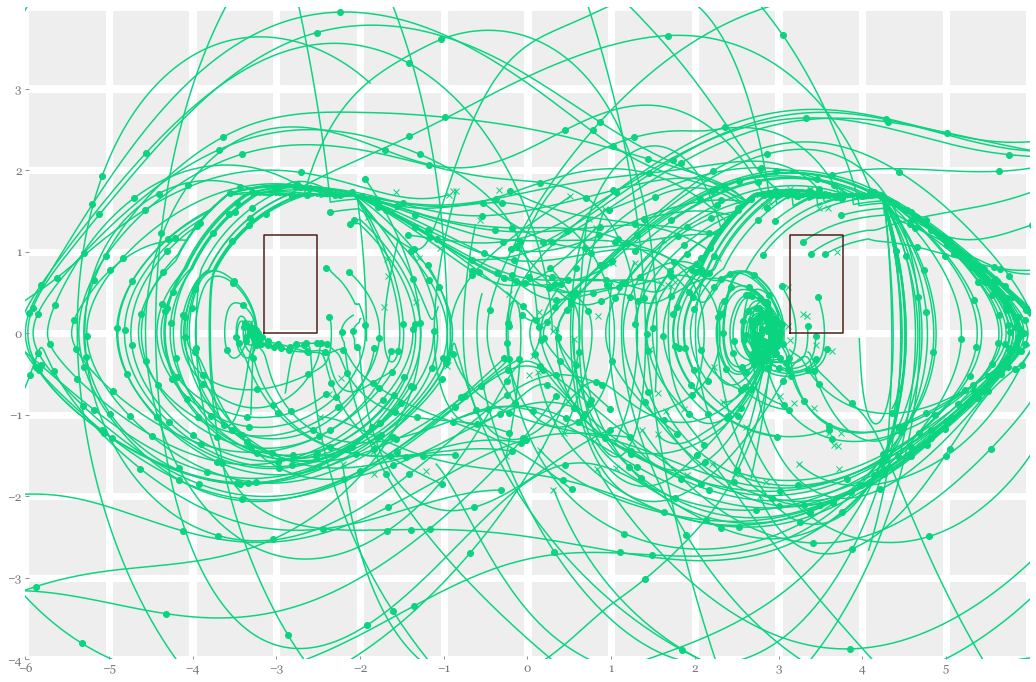

In [19]:
# Vary by randomizing start and end states

import ilqr
import csv
import level_sets

# Initialize the dynamics
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsNopeV_reachset.json")
vehicle = InvertedPendulum()
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
#safe_vehicle = vehicle
timestep_length = 0.01

# Initialize the traces' memory objects
N = 1000
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))

# Initialize the figure
fig = plt.figure(figsize=[18,12])
plt.axis([-6,6,-4,4])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(-4,4))

dotTimes = np.arange(0,N,100)

OptimizedTraces = []

# Repeat optimization for multiple starting states
for ii in range(101):
    # Forward simulate the dynamics with zero control
    startingState = np.copy(startingStates[ii])
    states_init[:,0] = startingState
    for i in np.arange(0,N):
        control_init[:,i] = np.zeros((safe_vehicle.dimU,))
        states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])

    # Optimize the trajectory
    Qprox = np.diag([1,1])
    goal_state = np.copy(endingGoals[ii])
    #goal_state[1] = 0
    terminalCost = of.TerminalCost(qof.QuadraticStateCost(
            dlqr.QuadraticForm(vehicle.dimZ,Qprox,
                               -2*Qprox*np.matrix(goal_state).T,
                               np.dot(np.dot(goal_state.transpose(),Qprox),goal_state) )
            ) * 80)
    mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                                timestep_length,
                                                                                safe_vehicle,
                                                                                Agent_objective,
                                                                                terminal_cost = terminalCost * (1/timestep_length),
                                                                                neverRetreat=True,ITER_NUM=15)
    
    # Plot the iterative LQR optimized trajectory
    #thiscolor = colors[0][ii%9]
    thiscolor = colors[2][1]
    plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=thiscolor)
    plt.plot(mintervener_method_states[0,dotTimes],
             mintervener_method_states[1,dotTimes],
             'ro',color=thiscolor)
    plt.plot(goal_state[0],goal_state[1],'x',color=thiscolor)
    OptimizedTraces.append(mintervener_method_states)

    # Export
    aug_controls = np.append(mintervener_method_controls[0,:],[0])
    with open('export/pendulumAgent_NoLowVeloAt5Tenths'+str(ii)+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(mintervener_method_states[0,:])
        writer.writerow(mintervener_method_states[1,:])
        writer.writerow(aug_controls)
        
# Plot the constraint
obsAngTick = 5
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
ys = np.array([-10,-10, 10, 10,-10])
#ys = ys * 0.12
ys = ys * 0.06 + 0.6
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         np.array(ys),
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         np.array(ys),
         color=colors[1][0])
plt.plot(np.array([angle1+2*np.pi,angle2+2*np.pi,angle2+2*np.pi,angle1+2*np.pi,angle1+2*np.pi]),
         np.array(ys),
         color=colors[1][0])

plt.show
plt.savefig("NoLowVeloAt5Tenths_TaxiDistro_15Iters.pdf")
# 0:Rust, 1:Turquoise, 2:Sand, 3:Indigo, 4:Teal, 5:Spring, 6:Flesh, 7:Magenta, 8:Gray

In [20]:
with open('export/pendulumAgent_startEnds_NoLowVeloAt5Tenths_TaxiDistro_15Iters'+'.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(range(0,100))
    writer.writerow([start[0] for start in startingStates])
    writer.writerow([start[1] for start in startingStates])
    writer.writerow([goal[0] for goal in endingGoals])
    writer.writerow([goal[1] for goal in endingGoals])

Initial cost is  [[178.85080649]]
Initialization's cost is  178.85080648570275
1 168.66979543671363
2 4.3653591265399045
3 0.6200990589783952
Initial cost is  [[13117.51483836]]
Initial cost is  [[199898.97713031]]
Initial cost is  [[2818.89968407]]
Initialization's cost is  2818.899684067443
1 1854.725541333636
2 1520.9435772068844
3 1402.7774722775168
Initial cost is  [[137198.24169811]]
Initial cost is  [[949.76754248]]
Initialization's cost is  949.7675424817851
1 919.029291995899
2 4.394955064838825
3 0.07144831808054786
Initial cost is  [[44853.67513755]]
Initial cost is  [[210617.95532603]]
Initial cost is  [[17215.96349563]]
Initial cost is  [[145851.96232216]]
Initial cost is  [[129344.87404193]]
Initial cost is  [[196.66697549]]
Initialization's cost is  196.66697548805905
1 5.7771076406596915
2 2.8088501597613025
3 2.643461247876948
Initial cost is  [[170499.11064434]]
Initial cost is  [[2651.39925493]]
Initialization's cost is  2651.3992549336654
1 1574.7943717955945
2 1164

1 2325.1524148611666
2 17.135789166075654
3 0.22402898308001867
Initial cost is  [[15462.26564355]]
Initial cost is  [[167850.32404338]]
Initial cost is  [[48229.6222891]]
Initial cost is  [[48912.84946671]]
Initial cost is  [[268422.49291195]]
Initial cost is  [[2689.55662444]]
Initialization's cost is  2689.5566244440797
1 2213.5257954214003
2 2064.1302865960183
3 1820.7652604729774
Initial cost is  [[153030.34520892]]
Initial cost is  [[234824.62650311]]
Initial cost is  [[81.22397506]]
Initialization's cost is  81.2239750612861
1 19.57303438283857
2 4.638384697791101
3 0.2012543306763592
Initial cost is  [[203794.64724085]]
Initial cost is  [[1839.99090733]]
Initialization's cost is  1839.990907332603
1 1185.681295002329
2 659.7082021386686
3 18.882252632813948
Initial cost is  [[2859.77360046]]
Initialization's cost is  2859.773600459722
1 2111.058044666603
2 1982.8139657104482
3 1727.1745263280734
Initial cost is  [[72021.93169853]]
Initial cost is  [[149317.75402288]]
Initial co

3 1.9800930807826742
Initial cost is  [[2821.38484764]]
Initialization's cost is  2821.384847638601
1 1907.4383918398858
2 1612.7925340185361
3 1457.8016357429467
Initial cost is  [[2826.58337411]]
Initialization's cost is  2826.5833741107367
1 2376.28880996172
2 27.753492383532482
3 0.3937154433583191
Initial cost is  [[80.95841824]]
Initialization's cost is  80.95841824186276
1 46.63046163356952
2 0.5586823583231924
3 0.0431368169308404
Initial cost is  [[78.12349402]]
Initialization's cost is  78.12349401784992
1 18.436099177010803
2 4.162989977557695
3 0.9372098026783079
Initial cost is  [[218.45289952]]
Initialization's cost is  218.45289952356816
1 64.45693505326857
2 8.051048370980627
3 0.189159228923249
Initial cost is  [[69.45848247]]
Initialization's cost is  69.4584824728983
1 13.295790865084784
2 2.6334278203029426
3 1.6751725493573777
Initial cost is  [[177.79384331]]
Initialization's cost is  177.79384330904995
1 71.56857676544502
2 5.7630400827620125
3 5.43996474206013
I

<function matplotlib.pyplot.show(close=None, block=None)>

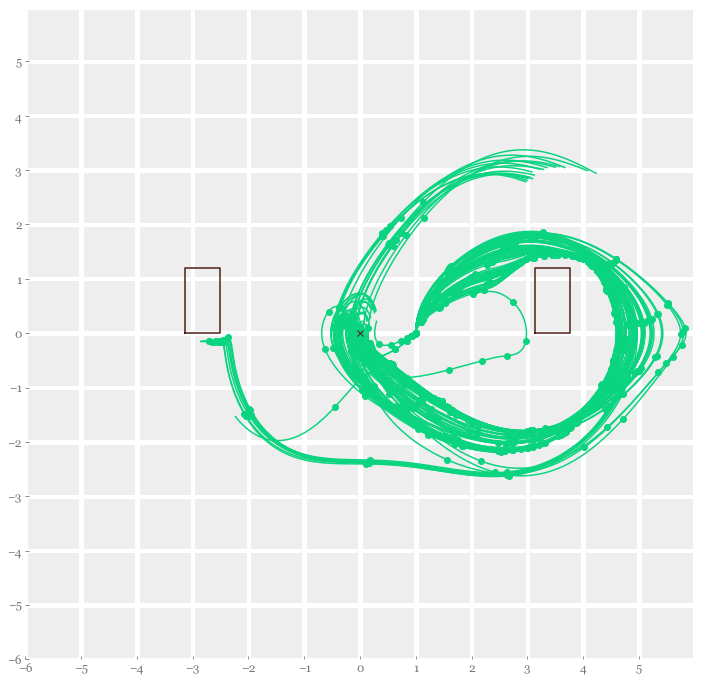

In [21]:
# Vary by randomizing initial control sequence

import ilqr
import csv
import level_sets

# Initialize the dynamics
safeLevel = level_sets.GriddedLevelSetFunction("reachsets/invertedPendulum5TenthsNopeV_reachset.json")
vehicle = InvertedPendulum()
safe_vehicle = dyn.MinimumInterventionDynamicsWrapper(vehicle,safeLevel)
timestep_length = 0.01

# Initialize the traces' memory objects
N = 1000
startingState = [1,0]
states_init = np.zeros((safe_vehicle.dimZ,N+1))
control_init = np.zeros((safe_vehicle.dimU,N))

# Initialize the figure
fig = plt.figure(figsize=[12,12])
plt.axis([-6,6,-6,6])
ax = fig.axes[0]
muteAxes(ax,range(-6,6),range(-6,6))

dotTimes = np.arange(0,N,100)

# Repeat optimization for multiple starting states
for ii in range(1,100):
    cost = 999999
    while cost > 10000:
        # Forward simulate the dynamics with zero control
        states_init[:,0] = startingState
        cost = 0
        #control_init[:,-1] = np.zeros((safe_vehicle.dimU,))
        constant_control = np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,))
        for i in np.arange(0,N):
            #control_init[:,i] = control_init[:,i-1] + timestep_length*(np.random.rand(safe_vehicle.dimU,)*2 - np.ones((safe_vehicle.dimU,)))
            control_init[:,i] = constant_control
            states_init[:,i+1] = states_init[:,i] + timestep_length * safe_vehicle.f(states_init[:,i],control_init[:,i])
            cost = cost + timestep_length*Agent_objective.f(states_init[:,i],control_init[:,i],i)
        cost = cost + terminalCost.f(states_init[:,N])
        print("Initial cost is ",cost)
        
    # Optimize the trajectory
    mintervener_method_states, mintervener_method_controls = ilqr.iterative_LQR(states_init,control_init,
                                                                                timestep_length,
                                                                                safe_vehicle,
                                                                                Agent_objective,
                                                                                terminal_cost = terminalCost * (1/timestep_length),
                                                                                neverRetreat=True,ITER_NUM=4)
    
    # Plot the iterative LQR optimized trajectory
    plt.plot(mintervener_method_states[0,:],mintervener_method_states[1,:],color=colors[2][1])
    plt.plot(mintervener_method_states[0,dotTimes],
             mintervener_method_states[1,dotTimes],
             'ro',color=colors[2][1])

    # Export
    aug_controls = np.append(mintervener_method_controls[0,:],[0])
    with open('export/pendulumAgent_5TenthsNopeVObstacleTruncated'+str(ii)+'.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(mintervener_method_states[0,:])
        writer.writerow(mintervener_method_states[1,:])
        writer.writerow(aug_controls)
        
# Plot the goal point
plt.plot(goal_state[0],goal_state[1],'x',color=colors[1][0])
# Plot the constraint
obsAngTick = 5
angle1 = ( obsAngTick   /10)*2*np.pi
angle2 = ((obsAngTick+1)/10)*2*np.pi
ys = np.array([-10,-10, 10, 10,-10])
#ys = ys * 0.12
ys = ys * 0.06 + 0.6
plt.plot(np.array([angle1,angle2,angle2,angle1,angle1]),
         np.array(ys),
         color=colors[1][0])
plt.plot(np.array([angle1-2*np.pi,angle2-2*np.pi,angle2-2*np.pi,angle1-2*np.pi,angle1-2*np.pi]),
         np.array(ys),
         color=colors[1][0])

plt.show